In [1]:
pip install textblob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 821.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 1.8 MB/s eta 0:00:0000:0100:01m
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Scraping https://www.amazon.in
Response status code: 503
Failed to fetch content from: https://www.amazon.in, Page 1. Status code: 503
Scraping https://www.ajio.com
Response status code: 200
Parsing HTML content...
Searching for keywords...
Keyword 'shopping' found on: https://www.ajio.com, Page 1
SMS notification sent successfully
SMS Notification Sent
Scraping https://www.flipkart.com
Response status code: 200
Parsing HTML content...
Searching for keywords...
Keyword 'shopping' found on: https://www.flipkart.com, Page 1
SMS notification sent successfully
SMS Notification Sent
Scraping Instagram...
Loaded session from instagram_session.


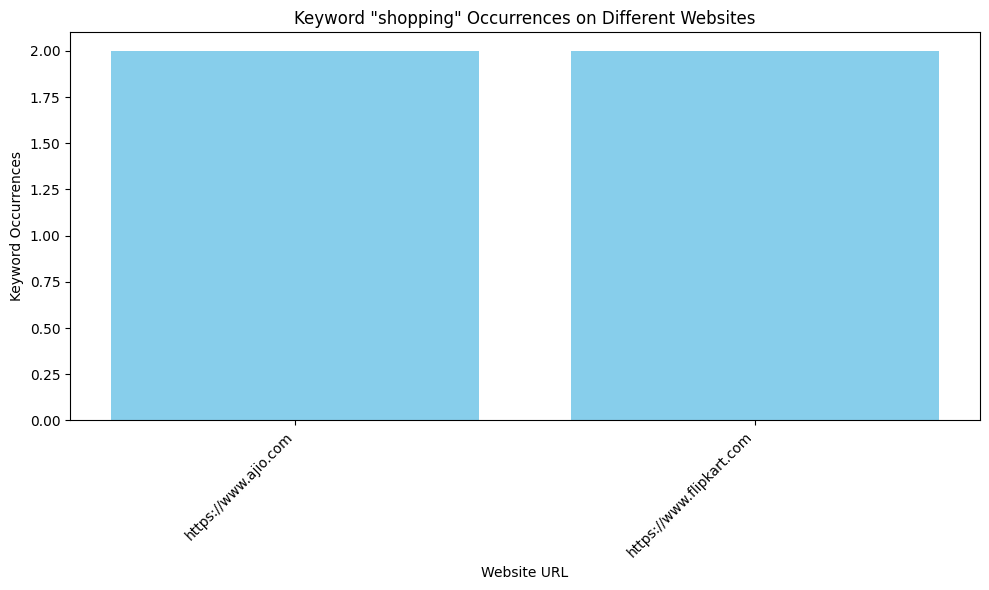

Scraping terminated


In [1]:
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox, simpledialog
import requests
from bs4 import BeautifulSoup
import csv
import threading
import datetime
import os
import schedule
import time
import instaloader
import matplotlib.pyplot as plt

# Twilio credentials
TWILIO_ACCOUNT_SID = ""
TWILIO_AUTH_TOKEN = ""
TWILIO_PHONE_NUMBER = ""
RECIPIENT_PHONE_NUMBER = ""

# List of websites to search through
website_list = [
    "https://www.amazon.in",
    "https://www.ajio.com",
    "https://www.flipkart.com",
    # Add more websites here
]

# Global variables
scraping_active = True
total_websites = len(website_list)
current_website_index = 0

# Instagram login credentials
INSTAGRAM_USERNAME = ""
INSTAGRAM_PASSWORD = ""

# Default login credentials
DEFAULT_USERNAME = "admin"
DEFAULT_PASSWORD = "admin"

# Function to authenticate the user
def authenticate_user():
    while True:
        username = simpledialog.askstring("Login", "Enter username:", parent=root)
        if username == DEFAULT_USERNAME:
            password = simpledialog.askstring("Login", "Enter password:", parent=root, show='*')
            if password == DEFAULT_PASSWORD:
                return True
            else:
                messagebox.showerror("Login Failed", "Invalid password. Please try again.")
        else:
            messagebox.showerror("Login Failed", "Invalid username. Please try again.")
        if username is None:
            return False

# Function to start scheduled scraping with reverse countdown timer
def start_scheduled_scraping(interval):
    schedule.every(interval).minutes.do(perform_scraping)
    while scraping_active:
        for i in range(interval * 60, -1, -1):
            if scraping_active:
                countdown_label["text"] = f"Next scraping in {i // 60} minutes {i % 60} seconds"
                time.sleep(1)
                root.update()  # Update the Tkinter window
            else:
                break
        schedule.run_pending()

def fetch_with_retry(url, max_retries=3):
    """Fetch content from URL with retries"""
    for _ in range(max_retries):
        try:
            response = requests.get(url)
            return response
        except requests.RequestException as e:
            print("Request failed:", e)
            continue
    return None

def perform_scraping():
    global scraping_active, current_website_index
    keywords = keyword_entry.get().split(",")  # Get keywords entered by the user
    if not keywords:
        print("Please enter at least one keyword.")
        return
    
    result_text.delete('1.0', tk.END)  # Clear previous results
    website_data = []
    instagram_data = []
    
    # Scrape from websites
    for i, website_url in enumerate(website_list, start=1):
        current_website_index = i
        if not scraping_active:
            break  # Terminate scraping if user clicked "Terminate" button
        try:
            print("Scraping", website_url)  # Added for debugging
            # Initialize page number for pagination
            page_number = 1
            while True:
                response = fetch_with_retry(f"{website_url}?page={page_number}")
                print("Response status code:", response.status_code)  # Added for debugging
                
                if response.status_code == 200:
                    print("Parsing HTML content...")
                    soup = BeautifulSoup(response.text, 'html.parser')
                    
                    print("Searching for keywords...")
                    for keyword in keywords:
                        if keyword.lower() in soup.get_text().lower():
                            keyword_found_message = f"Keyword '{keyword}' found on: {website_url}, Page {page_number}"
                            print(keyword_found_message)
                            result_text.insert(tk.END, keyword_found_message + "\n")
                            website_data.append((keyword, website_url, page_number, datetime.datetime.now().strftime("%H:%M"), datetime.datetime.now().strftime("%Y-%m-%d")))
                            send_sms_notification(keyword_found_message)  # Send SMS notification
                            print("SMS Notification Sent")
                    
                    # Check if there is a next page
                    next_page_link = soup.find("a", class_="next-page")
                    if next_page_link and page_number <= 3:
                        page_number += 1
                    else:
                        break  # No more pages, exit the loop
                else:
                    print(f"Failed to fetch content from: {website_url}, Page {page_number}. Status code: {response.status_code}")
                    break  # Exit the loop if failed to fetch page
        except Exception as e:
            print("Error scraping", website_url, ":", str(e))  # Added for debugging

    # Scrape from Instagram
    try:
        print("Scraping Instagram...")
        loader = instaloader.Instaloader()
        # Login to Instagram
        loader.load_session_from_file(INSTAGRAM_USERNAME, filename="instagram_session")
        usernames = ["cobuy.in"]  # List of usernames
        for username in usernames:
            profile = instaloader.Profile.from_username(loader.context, username)
            user_posts = profile.get_posts()
            for post in user_posts:
                if post.caption is not None:
                    # Extract content from the caption
                    caption = post.caption.encode('ascii', 'ignore').decode('ascii')  # Remove emojis
                    for keyword in keywords:
                        if keyword.lower() in caption.lower():
                            # Extract 2 sentences above and 2 sentences below the keyword
                            sentences = caption.split(".")
                            for i, sentence in enumerate(sentences):
                                if keyword.lower() in sentence.lower():
                                    start_index = max(0, i - 2)
                                    end_index = min(len(sentences), i + 3)
                                    extracted_content = " ".join(sentences[start_index:end_index])
                                    # Replace newline characters with spaces
                                    extracted_content = extracted_content.replace("\n", " ")
                                    # Store the extracted content in the Instagram data list
                                    instagram_data.append((keyword, username, extracted_content, datetime.datetime.now().strftime("%H:%M"), datetime.datetime.now().strftime("%Y-%m-%d")))
                                    break
    except instaloader.exceptions.ProfileNotExistsException as e:
        print(f"Profile '{e}' does not exist.")
    except Exception as e:
        print("Error scraping Instagram:", str(e))
    
    if website_data:
        export_website_data(website_data)
        messagebox.showinfo("Export Successful", "Website data exported successfully.")
        create_visualization(keywords)
    
    if instagram_data:
        export_instagram_data(instagram_data)
        messagebox.showinfo("Export Successful", "Instagram data exported successfully.")

def create_visualization(keywords):
    try:
        # Read the scraped data from the CSV file
        scraped_data = []
        with open("website_data.csv", "r", newline="", encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row
            for row in reader:
                scraped_data.append(row)

        # Process the data to count keyword occurrences on each website
        for keyword in keywords:
            keyword_counts = {}
            for data in scraped_data:
                if data[0].lower() == keyword.lower():
                    website_url = data[1]
                    if website_url in keyword_counts:
                        keyword_counts[website_url] += 1
                    else:
                        keyword_counts[website_url] = 1

            # Create a bar chart to visualize keyword occurrences on different websites
            plt.figure(figsize=(10, 6))
            plt.bar(keyword_counts.keys(), keyword_counts.values(), color='skyblue')
            plt.xlabel('Website URL')
            plt.ylabel('Keyword Occurrences')
            plt.title(f'Keyword "{keyword}" Occurrences on Different Websites')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        messagebox.showerror("Visualization Error", f"An error occurred while creating the visualization: {str(e)}")

def export_website_data(website_data):
    file_exists = os.path.isfile("website_data.csv")
    with open("website_data.csv", "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        if not file_exists:
            writer.writerow(["Keyword", "Website URL", "Page Number", "Time", "Date"])  # Write header if file doesn't exist
        writer.writerows(website_data)  # Append data

def export_instagram_data(instagram_data):
    file_exists = os.path.isfile("instagram_data.csv")
    with open("instagram_data.csv", "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        if not file_exists:
            writer.writerow(["Keyword", "Username", "Content", "Time", "Date"])  # Write header if file doesn't exist
        writer.writerows(instagram_data)  # Append data

def terminate_scraping():
    global scraping_active
    scraping_active = False
    print("Scraping terminated")  # Added for debugging
    authenticate_user()  # Redirect to login window

def send_sms_notification(message):
    try:
        url = f"https://api.twilio.com/2010-04-01/Accounts/{TWILIO_ACCOUNT_SID}/Messages.json"
        data = {
            "From": TWILIO_PHONE_NUMBER,
            "To": RECIPIENT_PHONE_NUMBER,
            "Body": message
        }
        response = requests.post(url, data=data, auth=(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN))
        if response.status_code == 201:
            print("SMS notification sent successfully")
        else:
            print("Failed to send SMS notification:", response.text)
    except Exception as e:
        print("Failed to send SMS notification:", e)

# Create the main window
root = tk.Tk()
root.title("Website & Instagram Keyword Scrapper")

# Authenticate the user
if not authenticate_user():
    root.destroy()

# Create and place widgets
keyword_label = ttk.Label(root, text="Enter Keyword(s):")
keyword_label.grid(row=0, column=0, padx=5, pady=5)

keyword_entry = ttk.Entry(root, width=50)
keyword_entry.grid(row=0, column=1, padx=5, pady=5)

interval_label = ttk.Label(root, text="Scraping Interval (minutes):")
interval_label.grid(row=1, column=0, padx=5, pady=5)

interval_entry = ttk.Entry(root, width=10)
interval_entry.grid(row=1, column=1, padx=5, pady=5)

start_button = ttk.Button(root, text="Start Scraping", command=lambda: start_scheduled_scraping(int(interval_entry.get())))
start_button.grid(row=2, column=0, columnspan=2, padx=5, pady=5)

terminate_button = ttk.Button(root, text="Terminate", command=terminate_scraping)
terminate_button.grid(row=2, column=2, padx=5, pady=5)

progress_label = ttk.Label(root, text="")
progress_label.grid(row=3, column=0, columnspan=3, padx=5, pady=5)

progress_bar = ttk.Progressbar(root, orient=tk.HORIZONTAL, length=300, mode="determinate")
progress_bar.grid(row=4, column=0, columnspan=3, padx=5, pady=5)

result_text = scrolledtext.ScrolledText(root, width=80, height=20, wrap=tk.WORD)
result_text.grid(row=5, column=0, columnspan=3, padx=5, pady=5)

countdown_label = ttk.Label(root, text="")
countdown_label.grid(row=6, column=0, columnspan=3, padx=5, pady=5)

root.mainloop()


In [2]:
import csv
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tkinter as tk
from tkinter import messagebox

def main(keywords):
    website_data = []
    instagram_data = []

    try:
        with open("website_data.csv", "r", newline="", encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                if any(keyword.lower() in row[0].lower() for keyword in keywords):
                    website_data.append(row)
    except Exception as e:
        print("Error reading website data:", str(e))
        messagebox.showerror("Website Data Error", f"An error occurred while reading website data: {str(e)}")

    try:
        with open("instagram_data.csv", "r", newline="", encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                if any(keyword.lower() in row[0].lower() for keyword in keywords):
                    instagram_data.append(row)
    except Exception as e:
        print("Error reading Instagram data:", str(e))
        messagebox.showerror("Instagram Data Error", f"An error occurred while reading Instagram data: {str(e)}")

    if website_data or instagram_data:
        perform_regression_analysis(website_data, instagram_data, keywords)


def perform_regression_analysis(website_data, instagram_data, keywords):
    try:
        X = []
        y = []

        # Use a dictionary to store the data from both sources
        data = {"website": website_data, "instagram": instagram_data}

        # Iterate through data sources
        for source, source_data in data.items():
            for row in source_data:
                if row[0].lower() in keywords:
                    # Convert date and time to a numerical value
                    date_time = datetime.datetime.strptime(row[4] + ' ' + row[3], "%Y-%m-%d %H:%M")
                    X.append(date_time.timestamp())
                    y.append(1)  # We assume 1 hour availability

        print("X:", X)
        print("y:", y)

        # Reshape y to match the input shape required by sklearn
        y = np.array(y).reshape(-1, 1)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print("X_train:", X_train)
        print("X_test:", X_test)
        print("y_train:", y_train)
        print("y_test:", y_test)

        # Perform linear regression
        regressor = LinearRegression()
        regressor.fit(np.array(X_train).reshape(-1, 1), y_train)

        # Make predictions
        y_pred = regressor.predict(np.array(X_test).reshape(-1, 1))

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print("Root Mean Squared Error:", rmse)

        # Predict the next availability
        last_timestamp = X[-1]
        predicted_time = y_pred[-1][0]
        next_date = datetime.datetime.fromtimestamp(last_timestamp + predicted_time)
        print("Predicted Next Availability Date:", next_date.strftime("%Y-%m-%d %H:%M:%S"))

        # Display the result in the GUI
        result_text.insert(tk.END, f"Predicted Next Availability Date: {next_date.strftime('%Y-%m-%d %H:%M:%S')}\n")
    except Exception as e:
        print("Error performing regression analysis:", str(e))
        messagebox.showerror("Regression Analysis Error", f"An error occurred during regression analysis: {str(e)}")


def get_keywords():
    keywords = keyword_entry.get().split(",")
    return [keyword.strip() for keyword in keywords]


# Create GUI
root = tk.Tk()
root.title("Regression Analysis")

keyword_label = tk.Label(root, text="Enter Keywords (comma separated):")
keyword_label.pack()

keyword_entry = tk.Entry(root)
keyword_entry.pack()

analyze_button = tk.Button(root, text="Perform Regression Analysis", command=lambda: main(get_keywords()))
analyze_button.pack()

result_text = tk.Text(root)
result_text.pack()

root.mainloop()


X: [1713765540.0, 1713767820.0, 1713767820.0, 1713767820.0]
y: [1, 1, 1, 1]
X_train: [1713767820.0, 1713765540.0, 1713767820.0]
X_test: [1713767820.0]
y_train: [[1]
 [1]
 [1]]
y_test: [[1]]
Root Mean Squared Error: 0.0
Predicted Next Availability Date: 2024-04-22 12:07:01
